In [2]:
using Pkg, Revise
#Pkg.activate("..")
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot
import DataFrames

In [3]:
using Clapeyron

glycine_data = """Clapeyron Database File
My SolidHfus Parameters
species,Mw,Tm,Hfus
glycine,75.07,569,13600
"""

like_parameter = """Clapeyron Database File
PCSAFT Like Parameters [csvtype = like,grouptype = PCSAFT]
species,Mw,segment,sigma,epsilon,n_H,n_e
water,18.015,1.2047,2.7927,353.95,1,1
glycine,75.07,3.79,2.61,320,1,1
"""

unlike_parameter = """Clapeyron Database File
PCSAFT Unlike Parameters [csvtype = unlike,grouptype = PCSAFT]
species1,species2,k
glycine,water,-0.0665
"""

assoc_parameter = """Clapeyron Database File
PCSAFT Assoc Parameters [csvtype = assoc,grouptype = PCSAFT]
species1,site1,species2,site2,epsilon_assoc,bondvol
water,H,water,e,2425.67,0.0451
glycine,H,glycine,e,1539.53,0.025
glycine,H,water,e,1982.6,0.033484136
water,H,glycine,e,1982.6,0.033484136
"""

components = ["water", "glycine"]

model = CompositeModel(components;
                       fluid = PCSAFT,
                       solid = SolidHfus,
                       solid_userlocations = [glycine_data],
                       fluid_userlocations = [like_parameter, unlike_parameter, assoc_parameter])

println("Sites:         ", model.fluid.sites)
println("bondvol:       ", model.fluid.params.bondvol)
println("epsilon_assoc: ", model.fluid.params.epsilon_assoc)
println("sigma:         ", model.fluid.params.sigma)
println("epsilon:       ", model.fluid.params.epsilon)

# Solubility at 298.15 K
R = 8.314; T = 298.15; P = 1e5; Tm = 569.0; Hfus = 13600.0
ln_x_ideal = -Hfus/R * (1/T - 1/Tm)

println("\nx_glycine | ln(γ) | γ | f(x)")
for x in [0.01, 0.02, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30]
    z = [1-x, x]
    lnγ = activity_coefficient(model.fluid, P, T, z)
    f = log(x) + lnγ[2] - ln_x_ideal
    println("  $x  |  $(round(lnγ[2],digits=4))  |  $(round(exp(lnγ[2]),digits=4))  |  $(round(f,digits=4))")
end

Sites:         SiteParam["water" => ["H" => 1, "e" => 1], "glycine" => ["H" => 1, "e" => 1]]
bondvol:       AssocParam{Float64}("bondvol")[0.0451, 0.033484136, 0.033484136, 0.025]
epsilon_assoc: AssocParam{Float64}("epsilon_assoc")[2425.67, 1982.6, 1982.6, 1539.53]
sigma:         PairParam{Float64}("sigma")["water", "glycine"]
epsilon:       PairParam{Float64}("epsilon")["water", "glycine"]

x_glycine | ln(γ) | γ | f(x)
  0.01  |  0.2205  |  1.2467  |  -1.773
  0.02  |  0.2361  |  1.2662  |  -1.0643
  0.05  |  0.284  |  1.3285  |  -0.1001
  0.07  |  0.3169  |  1.3728  |  0.2693
  0.1  |  0.3669  |  1.4432  |  0.6759
  0.15  |  0.4503  |  1.5687  |  1.1648
  0.2  |  0.5311  |  1.7008  |  1.5333
  0.25  |  0.607  |  1.8349  |  1.8323
  0.3  |  0.6763  |  1.9666  |  2.084


In [4]:
using Roots

# SLE objective function
function sle_obj(x_glycine)
    z = [1 - x_glycine, x_glycine]
    lnγ = activity_coefficient(model.fluid, P, T, z)
    return log(x_glycine) + lnγ[2] - ln_x_ideal
end

# Bisection between x=0.05 (f<0) and x=0.07 (f>0)
x_solution = find_zero(sle_obj, (0.05, 0.07))
println("Glycine solubility (mole fraction): ", x_solution)

Glycine solubility (mole fraction): 0.054828655242840287


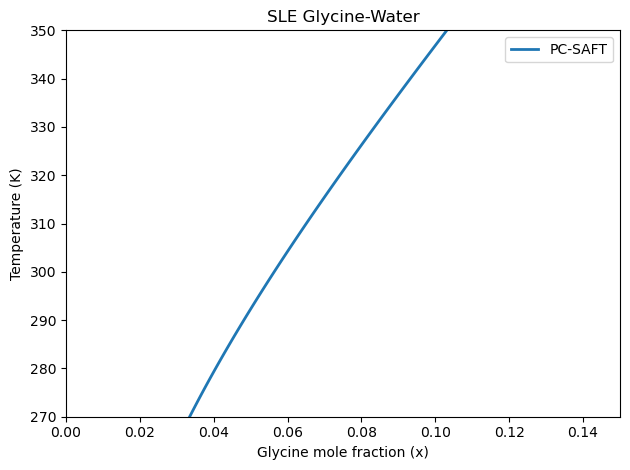

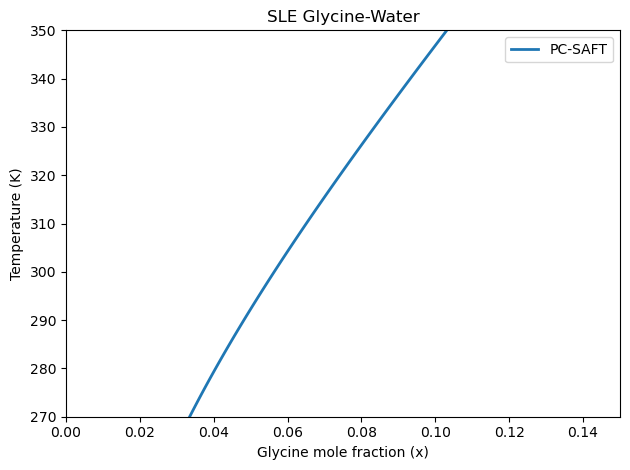

In [9]:
using Clapeyron, Roots

T = LinRange(270., 350., 81)
s = zeros(length(T))

Hfus = 13600.0
Tm   = 569.0
R    = 8.314
P    = 1e5

for i in 1:length(T)
    ln_x_ideal = -Hfus/R * (1/T[i] - 1/Tm)
    function sle_obj(x)
        z = [1-x, x]
        lnγ = activity_coefficient(model.fluid, P, T[i], z)
        return log(x) + lnγ[2] - ln_x_ideal
    end
    try
        s[i] = find_zero(sle_obj, (1e-4, 0.999))
    catch
        s[i] = NaN
    end
end

plt.clf()
plt.plot(s, T, linewidth=2, label="PC-SAFT")
plt.xlabel("Glycine mole fraction (x)")
plt.ylabel("Temperature (K)")
plt.title("SLE Glycine-Water")
plt.xlim(0, 0.15)
plt.ylim(270, 350)
plt.legend()
plt.tight_layout()
display(plt.gcf())

In [11]:
using DataFrames

df = DataFrame(
    Temperature_K = T,
    x_glycine = s)

println(df)

81×2 DataFrame
 Row │ Temperature_K  x_glycine 
     │ Float64        Float64   
─────┼──────────────────────────
   1 │         270.0  0.0335046
   2 │         271.0  0.0341763
   3 │         272.0  0.0348549
   4 │         273.0  0.0355404
   5 │         274.0  0.0362326
   6 │         275.0  0.0369315
   7 │         276.0  0.0376371
   8 │         277.0  0.0383493
   9 │         278.0  0.039068
  10 │         279.0  0.0397932
  11 │         280.0  0.0405247
  12 │         281.0  0.0412626
  13 │         282.0  0.0420068
  14 │         283.0  0.0427571
  15 │         284.0  0.0435136
  16 │         285.0  0.044276
  17 │         286.0  0.0450445
  18 │         287.0  0.0458188
  19 │         288.0  0.046599
  20 │         289.0  0.0473849
  21 │         290.0  0.0481764
  22 │         291.0  0.0489736
  23 │         292.0  0.0497762
  24 │         293.0  0.0505843
  25 │         294.0  0.0513977
  26 │         295.0  0.0522164
  27 │         296.0  0.0530402
  28 │         297.0  0.0